# hit-song-classifier

## Random Forest Classification

The first thing we'll do is define our imports and declare any constants.


In [16]:
# Define our imports
import numpy as np
import matplotlib.pyplot as plt
import os

from pyspark.sql import DataFrame, SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics


from sklearn.metrics import ConfusionMatrixDisplay

# Allocate enough memory for our Spark session
memory = "8g"
pyspark_submit_args = f"--driver-memory {memory} pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

# Define our constants
TARGET_DATA = "../../data/spotify_enhanced_dataset.csv"
RANDOM_SEED = 0
TARGET_FEATURES = [
    "popularity",
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
    "time_signature",
]

Next, we shall split our data in a 60-20-20 train_test_val split. Then we shall build our set of inputs X. We don't want to include the features `[song, artist, year]` since they are keys. We also should define our label `class` since that is our classification feature.

In [27]:
def feature_transformer(df: DataFrame) -> DataFrame:
    """Assembles feature vectors in dataframe

    Args:
        df (DataFrame): input

    Returns:
        DataFrame: feature-label dataframe
    """
    va = VectorAssembler(inputCols=TARGET_FEATURES, outputCol="features",handleInvalid = "keep")
    va_df = va.transform(df)
    return va_df


def load_data(filename: str) -> DataFrame:
    """Load data from file

    Args:
        filename (str): filename

    Returns:
        DataFrame: pyspark dataframe
    """
    spark = SparkSession.builder.appName("hit-song-classifier-rfc").getOrCreate()
    return spark.read.csv(filename, header=True, inferSchema=True, quote='"')


def split_data(df: DataFrame) -> tuple[DataFrame, DataFrame, DataFrame]:
    """Splits data to train, val, test splits

    Args:
        df (DataFrame): full dataframe

    Returns:
        DataFrame: _description_
    """
    train, val, test = df.randomSplit([0.6, 0.2, 0.2], seed=RANDOM_SEED)
    return train, val, test


df = feature_transformer(load_data(TARGET_DATA))


train_df, val_df, test_df = split_data(df)
print(f"Train: {train_df.count()}\nTest: {test_df.count()}\nVal: {val_df.count()}")

+-------+------------------+-------------------+------------------+-----------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-----------------+-------------------+
|summary|        popularity|       danceability|            energy|              key|          loudness|               mode|        speechiness|      acousticness|   instrumentalness|           liveness|            valence|             tempo|      duration_ms|     time_signature|
+-------+------------------+-------------------+------------------+-----------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-----------------+-------------------+
|  count|             32509|              32509|             32509|            32509|             32509|              32509|              32509|             

## Hyperparameter search: training multiple estimators

Here we will train multiple estimators with different hyperparameter settings. For RandomForestClassifiers, the hyperparameters we've chosen include `maxDepth` and `numTrees`.

In [29]:
# def train_estimators(
#     data: DataFrame,
#     estimator_type: any,
#     param_name: str,
#     param_vals: list[int],
#     **kwargs,
# ) -> list:
#     """Trains estimators

#     Args:
#         data (DataFrame): dataframe
#         estimator_type (RandomForestClassifier): estimator
#         param_name (str): parameter name
#         param_vals (list[int]): parameter values

#     Returns:
#         list: list of trained estimators
#     """
#     estimators = []
#     for val in param_vals:
#         estimator = estimator_type(**{param_name: val}, **kwargs)
#         fitted_models = estimator.fit(data)
#         estimators.append(fitted_models)
#         print(f"Training {fitted_models}")
#     return estimators

def train_estimators(
    data: DataFrame,
    estimator_type: any,
    param_name: str,
    param_vals: list,
    **kwargs,
) -> list:
    """Trains estimators

    Args:
        data (DataFrame): dataframe
        estimator_type (MultilayerPerceptronClassifier): estimator
        param_name (str): parameter name
        param_vals (list): parameter values

    Returns:
        list: list of trained estimators
    """
    estimators = []
    for val in param_vals:
        estimator = estimator_type(**{param_name: val}, **kwargs)
        fitted_models = estimator.fit(data)
        estimators.append(fitted_models)
        print(f"Training {fitted_models}")
    return estimators


### Hyperparameter search: `hidden layers`

Note that in Pyspark, the max depth is `30`.


In [31]:
hidden_layers = [
    [14, 1, 11],
    [14, 5, 11],
    [14, 10, 11],
    [14, 20, 11],
    [14, 50, 11],
    [14, 100, 11],
]

mlp = train_estimators(
    train_df,
    MultilayerPerceptronClassifier,
    "layers",
    hidden_layers,
    featuresCol="features",
    labelCol="class",
    seed=RANDOM_SEED,
)


Training MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_f827ac27c2d3, numLayers=3, numClasses=11, numFeatures=14
Training MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_048a57193d16, numLayers=3, numClasses=11, numFeatures=14
Training MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_c825b5eb9ba4, numLayers=3, numClasses=11, numFeatures=14
Training MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_cf5a468746ee, numLayers=3, numClasses=11, numFeatures=14
Training MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_5be35a812ee5, numLayers=3, numClasses=11, numFeatures=14
Training MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_f8ef03eb6913, numLayers=3, numClasses=11, numFeatures=14


We want to plot estimator scores to pick the estimator with the best score.

In [36]:
def score_model(models: list, data: DataFrame) -> list:
    """Scores models

    Args:
        estimators (list): list of estimators
        data (DataFrame): dataframe

    Returns:
        list: list of scores
    """
    evaluator = MulticlassClassificationEvaluator(
        labelCol="class", predictionCol="prediction", metricName="f1"
    )

    predicted = [model.transform(data) for model in models]
    return [evaluator.evaluate(pred) for pred in predicted]


print(f"train: {score_model(mlp, train_df)}")
print(f"val: {score_model(mlp, val_df)}")
print(f"test: {score_model(mlp, test_df)}")

train: [0.04098837012699831, 0.04098837012699831, 0.04098837012699831, 0.04098837012699831, 0.04098837012699831, 0.04098837012699831]
val: [0.04189415098975965, 0.04189415098975965, 0.04189415098975965, 0.04189415098975965, 0.04189415098975965, 0.04189415098975965]
test: [0.04070937800975881, 0.04070937800975881, 0.04070937800975881, 0.04070937800975881, 0.04070937800975881, 0.04070937800975881]


### Hyperparameter search: `numTrees`


In [35]:

hidden_layers = [
    [14, 1, 11],
    [14, 5, 11],
    [14, 10, 11],
    [14, 20, 11],
    [14, 50, 11],
    [14, 100, 11],
]

max_iter = [1, 5, 10, 20, 50, 100]
lr_max_iter_list = train_estimators(
    train_df,
    MultilayerPerceptronClassifier,
    "maxIter",
    max_iter,
    featuresCol="features",
    labelCol="class",
)



Py4JJavaError: An error occurred while calling o2103.fit.
: java.util.NoSuchElementException: Failed to find a default value for layers
	at org.apache.spark.ml.param.Params.$anonfun$getOrDefault$2(params.scala:756)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.ml.param.Params.getOrDefault(params.scala:756)
	at org.apache.spark.ml.param.Params.getOrDefault$(params.scala:753)
	at org.apache.spark.ml.PipelineStage.getOrDefault(Pipeline.scala:41)
	at org.apache.spark.ml.param.Params.$(params.scala:762)
	at org.apache.spark.ml.param.Params.$$(params.scala:762)
	at org.apache.spark.ml.PipelineStage.$(Pipeline.scala:41)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassifier.$anonfun$train$1(MultilayerPerceptronClassifier.scala:190)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassifier.train(MultilayerPerceptronClassifier.scala:184)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassifier.train(MultilayerPerceptronClassifier.scala:93)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:151)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:115)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)


### Evaluate the F1 score of the hyperparameters for `max_depth` and `num_trees`

In [ ]:
print(f"train: {score_model(rfc_trees, train_df)}")
print(f"val: {score_model(rfc_trees, val_df)}")
print(f"test: {score_model(rfc_trees, test_df)}")

train: [0.13408788281904452, 0.1227676485817295, 0.10702318546949614, 0.1097107361527679, 0.10970829462538828, 0.1125851890523203]
val: [0.1263232822628681, 0.11622870440685538, 0.10262042356062656, 0.10596866453854772, 0.10501061650555307, 0.10841326020070029]
test: [0.12002664640361543, 0.11694688542312373, 0.0987217092592679, 0.10277499520713505, 0.10461989718629988, 0.10564969773903111]


In [38]:
def plot_estimator_scores(models: list, param_name: str, param_vals: list[int]):
    """Plots the scores of a list of estimators"""

    train_score = score_model(models, train_df)
    val_score = score_model(models, val_df)
    test_score = score_model(models, test_df)

    # Get the best validation score and the index of the best estimator
    best_val_score = max(val_score)
    best_val_idx = val_score.index(best_val_score)

    # Plot metrics
    plt.figure()
    plt.plot(np.arange(len(train_score)), train_score, "go-", label="train")
    plt.plot(np.arange(len(val_score)), val_score, "ro-", label="val")
    plt.plot(np.arange(len(test_score)), test_score, "k:", label="test")
    # Place an X at the best validation score
    plt.scatter(best_val_idx, best_val_score, marker="x", color="r", s=200)

    # Additional formatting
    plt.ylim(0, 1.05)
    plt.xticks(ticks=np.arange(len(train_score)), labels=param_vals)
    plt.ylabel("score")
    plt.xlabel(param_name)
    plt.title(f"{models[0].__class__.__name__} score vs. {param_name}")

    # Output scores at max_depth of the best_validation_score
    plt.text(
        3.7 if len(train_score) < 6 else 4.7,
        0.3,
        f"train = {train_score[best_val_idx]:.3f}",
        c="g",
        ha="right",
    )
    plt.text(
        3.7 if len(train_score) < 6 else 4.7,
        0.2,
        f"validate = {best_val_score:.3f}",
        c="r",
        ha="right",
    )
    plt.text(
        3.7 if len(train_score) < 6 else 4.7,
        0.1,
        f"test = {test_score[best_val_idx]:.3f}",
        c="k",
        ha="right",
    )
    plt.legend()

CPU times: total: 62.5 ms
Wall time: 14.1 s


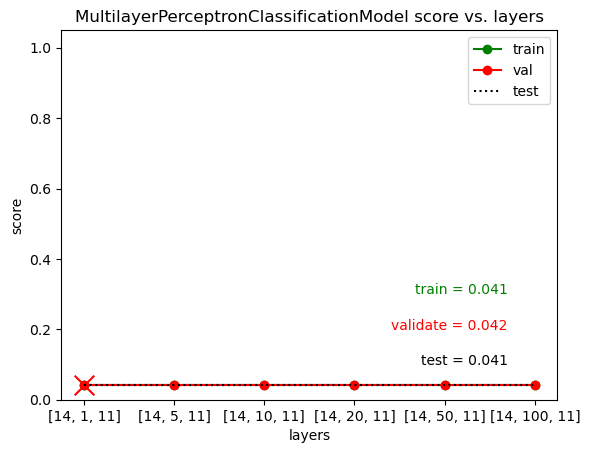

In [39]:
%%time
plot_estimator_scores(mlp, "layers", hidden_layers)

CPU times: user 176 ms, sys: 48.3 ms, total: 224 ms
Wall time: 5.89 s


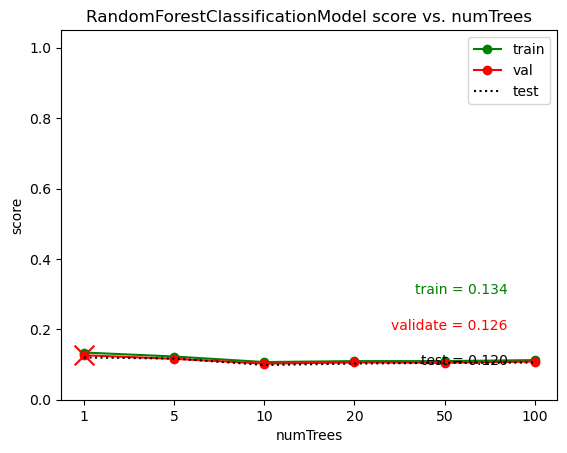

In [ ]:
%%time
plot_estimator_scores(rfc_trees, "numTrees", num_trees)

## Evaluation using Confusion Matrices

23/04/03 18:04:52 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/04/03 18:04:53 WARN DAGScheduler: Broadcasting large task binary with size 34.3 MiB


23/04/03 18:04:55 WARN DAGScheduler: Broadcasting large task binary with size 43.0 MiB


/usr/local/Caskroom/miniconda/base/envs/soen/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


23/04/03 18:04:57 WARN DAGScheduler: Broadcasting large task binary with size 34.2 MiB


23/04/03 18:04:59 WARN DAGScheduler: Broadcasting large task binary with size 34.3 MiB


/usr/local/Caskroom/miniconda/base/envs/soen/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


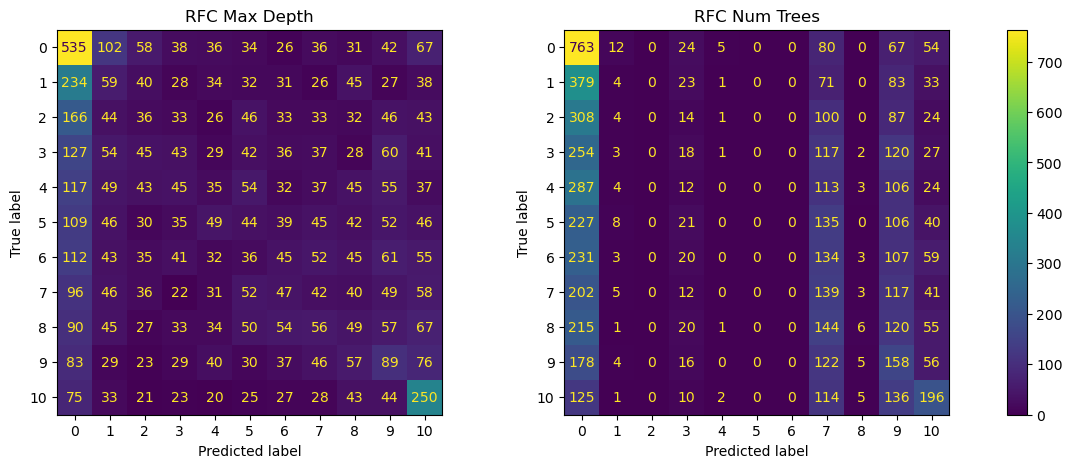

In [ ]:
# Declare models and model names
model_list = [rfc_multi, rfc_trees]
model_names = ["RFC Max Depth", "RFC Num Trees"]


def generate_confusion_matrix(model_list: list, val_df: DataFrame, test_df: DataFrame):
    """Generates a confusion matrix for each model in model_list"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for i, model in enumerate(model_list):
        val_score = score_model(model, val_df)
        best_val_score = max(val_score)
        best_val_idx = val_score.index(best_val_score)

        # Generate confusion matrix
        best_model = (
            model[best_val_idx].transform(test_df).select("class", "prediction")
        )
        predictionAndLabels = best_model.rdd.map(
            lambda row: (float(row["prediction"]), float(row["class"]))
        )
        class_names = (
            best_model.select("class")
            .distinct()
            .sort("class")
            .rdd.map(lambda row: row[0])
            .collect()
        )
        metrics = MulticlassMetrics(predictionAndLabels)
        con_mtrx = metrics.confusionMatrix().toArray().astype(int)

        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(
            confusion_matrix=con_mtrx, display_labels=class_names
        )
        disp.plot(ax=axes[i], colorbar=False)
        axes[i % 2].set_title(model_names[i % 2])

    # Add colorbar
    fig.colorbar(disp.im_, ax=axes.ravel().tolist())


generate_confusion_matrix(model_list, val_df, test_df)

## Putting it all together using Cross-Validation

Since we evaluated the hyperparameters separately above, we should create a Pipeline in which the best hyperparameters are determined grid-wise. This should automate what we did above.

In [ ]:
def cross_validator(train_data: DataFrame) -> CrossValidatorModel:
    """Performs cross validation"""

    # Define the estimator
    rfc = RandomForestClassifier(
        featuresCol="features",
        labelCol="class",
        seed=RANDOM_SEED,
    )

    # Define the parameter grid
    param_grid = (
        ParamGridBuilder()
        .addGrid(rfc.maxDepth, max_depth)
        .addGrid(rfc.numTrees, num_trees)
        .build()
    )

    # Define the evaluator using F1 score
    evaluator = MulticlassClassificationEvaluator(
        labelCol="class", predictionCol="prediction", metricName="f1"
    )

    # Create the cross validator with 5 folds
    cv = CrossValidator(
        estimator=rfc, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3
    )
    cv_model = cv.fit(train_data)

    return cv_model


cv_model = cross_validator(train_df)

23/04/03 18:05:18 WARN DAGScheduler: Broadcasting large task binary with size 1034.2 KiB
23/04/03 18:05:19 WARN DAGScheduler: Broadcasting large task binary with size 1652.4 KiB
23/04/03 18:05:19 WARN DAGScheduler: Broadcasting large task binary with size 1537.6 KiB
23/04/03 18:05:20 WARN DAGScheduler: Broadcasting large task binary with size 1144.0 KiB
23/04/03 18:05:21 WARN DAGScheduler: Broadcasting large task binary with size 1895.3 KiB
23/04/03 18:05:21 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/04/03 18:05:22 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/04/03 18:05:24 WARN DAGScheduler: Broadcasting large task binary with size 1491.9 KiB
23/04/03 18:05:25 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/03 18:05:26 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:05:27 WARN DAGScheduler: Broadcasting large task binary with size 1015.9 KiB


23/04/03 18:05:28 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


23/04/03 18:05:29 WARN DAGScheduler: Broadcasting large task binary with size 1486.9 KiB


23/04/03 18:05:30 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


23/04/03 18:05:33 WARN DAGScheduler: Broadcasting large task binary with size 1570.6 KiB


23/04/03 18:05:34 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


23/04/03 18:05:36 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


23/04/03 18:05:37 WARN DAGScheduler: Broadcasting large task binary with size 1286.7 KiB


23/04/03 18:05:38 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


23/04/03 18:05:40 WARN DAGScheduler: Broadcasting large task binary with size 1975.2 KiB


23/04/03 18:05:41 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


23/04/03 18:05:43 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


23/04/03 18:05:45 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


23/04/03 18:05:47 WARN DAGScheduler: Broadcasting large task binary with size 1150.7 KiB
23/04/03 18:05:47 WARN DAGScheduler: Broadcasting large task binary with size 1321.2 KiB
23/04/03 18:05:48 WARN DAGScheduler: Broadcasting large task binary with size 1488.9 KiB
23/04/03 18:05:48 WARN DAGScheduler: Broadcasting large task binary with size 1641.5 KiB
23/04/03 18:05:48 WARN DAGScheduler: Broadcasting large task binary with size 1762.6 KiB
23/04/03 18:05:48 WARN DAGScheduler: Broadcasting large task binary with size 1214.5 KiB
23/04/03 18:05:49 WARN DAGScheduler: Broadcasting large task binary with size 1379.9 KiB
23/04/03 18:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1996.6 KiB
23/04/03 18:05:50 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/04/03 18:05:50 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/04/03 18:05:51 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/04/03 18:05:51 WARN DAGSche

23/04/03 18:06:02 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB
23/04/03 18:06:03 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB


23/04/03 18:06:04 WARN DAGScheduler: Broadcasting large task binary with size 18.8 MiB


23/04/03 18:06:05 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
23/04/03 18:06:07 WARN DAGScheduler: Broadcasting large task binary with size 1144.0 KiB
23/04/03 18:06:07 WARN DAGScheduler: Broadcasting large task binary with size 1895.3 KiB
23/04/03 18:06:08 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/04/03 18:06:09 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/04/03 18:06:10 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


23/04/03 18:06:10 WARN DAGScheduler: Broadcasting large task binary with size 1000.0 KiB


23/04/03 18:06:11 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


23/04/03 18:06:12 WARN DAGScheduler: Broadcasting large task binary with size 1222.7 KiB


23/04/03 18:06:12 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


23/04/03 18:06:13 WARN DAGScheduler: Broadcasting large task binary with size 1443.0 KiB


23/04/03 18:06:14 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB


23/04/03 18:06:15 WARN DAGScheduler: Broadcasting large task binary with size 1590.6 KiB


23/04/03 18:06:16 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB


23/04/03 18:06:17 WARN DAGScheduler: Broadcasting large task binary with size 1644.4 KiB


23/04/03 18:06:19 WARN DAGScheduler: Broadcasting large task binary with size 25.2 MiB


23/04/03 18:06:20 WARN DAGScheduler: Broadcasting large task binary with size 1612.9 KiB


23/04/03 18:06:22 WARN DAGScheduler: Broadcasting large task binary with size 29.5 MiB


23/04/03 18:06:23 WARN DAGScheduler: Broadcasting large task binary with size 1489.0 KiB


23/04/03 18:06:24 WARN DAGScheduler: Broadcasting large task binary with size 33.3 MiB


23/04/03 18:06:25 WARN DAGScheduler: Broadcasting large task binary with size 1288.6 KiB


23/04/03 18:06:27 WARN DAGScheduler: Broadcasting large task binary with size 36.7 MiB


23/04/03 18:06:28 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB


23/04/03 18:06:30 WARN DAGScheduler: Broadcasting large task binary with size 24.3 MiB


23/04/03 18:06:32 WARN DAGScheduler: Broadcasting large task binary with size 1491.9 KiB


23/04/03 18:06:33 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/03 18:06:34 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:06:35 WARN DAGScheduler: Broadcasting large task binary with size 1015.9 KiB


23/04/03 18:06:36 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


23/04/03 18:06:37 WARN DAGScheduler: Broadcasting large task binary with size 1486.9 KiB


23/04/03 18:06:38 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


23/04/03 18:06:40 WARN DAGScheduler: Broadcasting large task binary with size 2043.0 KiB


23/04/03 18:06:41 WARN DAGScheduler: Broadcasting large task binary with size 17.1 MiB


23/04/03 18:06:43 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/03 18:06:45 WARN DAGScheduler: Broadcasting large task binary with size 24.3 MiB


23/04/03 18:06:47 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


23/04/03 18:06:49 WARN DAGScheduler: Broadcasting large task binary with size 33.0 MiB


23/04/03 18:06:51 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


23/04/03 18:06:55 WARN DAGScheduler: Broadcasting large task binary with size 42.7 MiB


23/04/03 18:06:57 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


23/04/03 18:07:01 WARN DAGScheduler: Broadcasting large task binary with size 53.2 MiB


23/04/03 18:07:04 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


23/04/03 18:07:08 WARN DAGScheduler: Broadcasting large task binary with size 63.8 MiB


23/04/03 18:07:10 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


23/04/03 18:07:15 WARN DAGScheduler: Broadcasting large task binary with size 74.2 MiB


23/04/03 18:07:18 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


23/04/03 18:07:22 WARN DAGScheduler: Broadcasting large task binary with size 83.7 MiB


23/04/03 18:07:25 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


23/04/03 18:07:30 WARN DAGScheduler: Broadcasting large task binary with size 91.9 MiB


23/04/03 18:07:33 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/03 18:07:36 WARN DAGScheduler: Broadcasting large task binary with size 60.8 MiB


23/04/03 18:07:40 WARN DAGScheduler: Broadcasting large task binary with size 1570.6 KiB


23/04/03 18:07:41 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


23/04/03 18:07:43 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


23/04/03 18:07:45 WARN DAGScheduler: Broadcasting large task binary with size 1286.7 KiB


23/04/03 18:07:46 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


23/04/03 18:07:48 WARN DAGScheduler: Broadcasting large task binary with size 1975.2 KiB


23/04/03 18:07:50 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


23/04/03 18:07:52 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


23/04/03 18:07:54 WARN DAGScheduler: Broadcasting large task binary with size 22.4 MiB


23/04/03 18:07:57 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


23/04/03 18:08:00 WARN DAGScheduler: Broadcasting large task binary with size 30.3 MiB


23/04/03 18:08:03 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:08:06 WARN DAGScheduler: Broadcasting large task binary with size 35.0 MiB


23/04/03 18:08:09 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:08:12 WARN DAGScheduler: Broadcasting large task binary with size 41.3 MiB


23/04/03 18:08:15 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:08:19 WARN DAGScheduler: Broadcasting large task binary with size 49.7 MiB


23/04/03 18:08:21 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:08:26 WARN DAGScheduler: Broadcasting large task binary with size 60.5 MiB


23/04/03 18:08:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:08:34 WARN DAGScheduler: Broadcasting large task binary with size 74.0 MiB


23/04/03 18:08:37 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:08:42 WARN DAGScheduler: Broadcasting large task binary with size 90.0 MiB


23/04/03 18:08:45 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:08:51 WARN DAGScheduler: Broadcasting large task binary with size 106.6 MiB


23/04/03 18:08:55 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:09:01 WARN DAGScheduler: Broadcasting large task binary with size 123.7 MiB


23/04/03 18:09:06 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:09:09 WARN DAGScheduler: Broadcasting large task binary with size 33.2 MiB


23/04/03 18:09:11 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


23/04/03 18:09:13 WARN DAGScheduler: Broadcasting large task binary with size 36.9 MiB


23/04/03 18:09:15 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


23/04/03 18:09:18 WARN DAGScheduler: Broadcasting large task binary with size 43.0 MiB


23/04/03 18:09:20 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/04/03 18:09:23 WARN DAGScheduler: Broadcasting large task binary with size 43.2 MiB


23/04/03 18:09:25 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/03 18:09:28 WARN DAGScheduler: Broadcasting large task binary with size 50.3 MiB


23/04/03 18:09:30 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


23/04/03 18:09:32 WARN DAGScheduler: Broadcasting large task binary with size 43.2 MiB


23/04/03 18:09:34 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/04/03 18:09:37 WARN DAGScheduler: Broadcasting large task binary with size 44.7 MiB


23/04/03 18:09:38 WARN DAGScheduler: Broadcasting large task binary with size 1813.9 KiB


23/04/03 18:09:40 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB


23/04/03 18:09:41 WARN DAGScheduler: Broadcasting large task binary with size 1223.8 KiB


23/04/03 18:09:43 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB


23/04/03 18:09:49 WARN DAGScheduler: Broadcasting large task binary with size 119.5 MiB


23/04/03 18:09:54 WARN DAGScheduler: Broadcasting large task binary with size 1150.7 KiB
23/04/03 18:09:54 WARN DAGScheduler: Broadcasting large task binary with size 1321.2 KiB
23/04/03 18:09:54 WARN DAGScheduler: Broadcasting large task binary with size 1489.0 KiB
23/04/03 18:09:54 WARN DAGScheduler: Broadcasting large task binary with size 1641.5 KiB
23/04/03 18:09:55 WARN DAGScheduler: Broadcasting large task binary with size 1762.6 KiB
23/04/03 18:09:55 WARN DAGScheduler: Broadcasting large task binary with size 1862.2 KiB
23/04/03 18:09:55 WARN DAGScheduler: Broadcasting large task binary with size 1946.9 KiB
23/04/03 18:09:55 WARN DAGScheduler: Broadcasting large task binary with size 2026.3 KiB
23/04/03 18:09:55 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/04/03 18:09:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/04/03 18:09:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/04/03 18:09:56 WARN DAGSche

23/04/03 18:10:15 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


23/04/03 18:10:16 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB


23/04/03 18:10:17 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB


23/04/03 18:10:19 WARN DAGScheduler: Broadcasting large task binary with size 18.8 MiB


23/04/03 18:10:20 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB


23/04/03 18:10:21 WARN DAGScheduler: Broadcasting large task binary with size 21.1 MiB


23/04/03 18:10:23 WARN DAGScheduler: Broadcasting large task binary with size 21.8 MiB


23/04/03 18:10:24 WARN DAGScheduler: Broadcasting large task binary with size 22.4 MiB


23/04/03 18:10:25 WARN DAGScheduler: Broadcasting large task binary with size 22.7 MiB


23/04/03 18:10:26 WARN DAGScheduler: Broadcasting large task binary with size 23.0 MiB


23/04/03 18:10:27 WARN DAGScheduler: Broadcasting large task binary with size 23.1 MiB


23/04/03 18:10:28 WARN DAGScheduler: Broadcasting large task binary with size 23.2 MiB


23/04/03 18:10:29 WARN DAGScheduler: Broadcasting large task binary with size 18.7 MiB


23/04/03 18:10:30 WARN DAGScheduler: Broadcasting large task binary with size 18.7 MiB


23/04/03 18:10:31 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
23/04/03 18:10:33 WARN DAGScheduler: Broadcasting large task binary with size 1144.0 KiB
23/04/03 18:10:33 WARN DAGScheduler: Broadcasting large task binary with size 1895.3 KiB
23/04/03 18:10:34 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/04/03 18:10:35 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/04/03 18:10:36 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
23/04/03 18:10:36 WARN DAGScheduler: Broadcasting large task binary with size 1000.0 KiB
23/04/03 18:10:37 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


23/04/03 18:10:38 WARN DAGScheduler: Broadcasting large task binary with size 1222.7 KiB


23/04/03 18:10:39 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


23/04/03 18:10:40 WARN DAGScheduler: Broadcasting large task binary with size 1443.0 KiB


23/04/03 18:10:41 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB


23/04/03 18:10:42 WARN DAGScheduler: Broadcasting large task binary with size 1590.6 KiB


23/04/03 18:10:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB


23/04/03 18:10:44 WARN DAGScheduler: Broadcasting large task binary with size 1644.4 KiB


23/04/03 18:10:46 WARN DAGScheduler: Broadcasting large task binary with size 25.2 MiB


23/04/03 18:10:47 WARN DAGScheduler: Broadcasting large task binary with size 1612.9 KiB


23/04/03 18:10:48 WARN DAGScheduler: Broadcasting large task binary with size 29.5 MiB


23/04/03 18:10:49 WARN DAGScheduler: Broadcasting large task binary with size 1489.0 KiB


23/04/03 18:10:51 WARN DAGScheduler: Broadcasting large task binary with size 33.3 MiB


23/04/03 18:10:52 WARN DAGScheduler: Broadcasting large task binary with size 1288.6 KiB


23/04/03 18:10:54 WARN DAGScheduler: Broadcasting large task binary with size 36.7 MiB


23/04/03 18:10:55 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB


23/04/03 18:10:57 WARN DAGScheduler: Broadcasting large task binary with size 39.4 MiB


23/04/03 18:11:00 WARN DAGScheduler: Broadcasting large task binary with size 41.6 MiB


23/04/03 18:11:02 WARN DAGScheduler: Broadcasting large task binary with size 43.3 MiB


23/04/03 18:11:05 WARN DAGScheduler: Broadcasting large task binary with size 44.5 MiB


23/04/03 18:11:07 WARN DAGScheduler: Broadcasting large task binary with size 45.3 MiB


23/04/03 18:11:10 WARN DAGScheduler: Broadcasting large task binary with size 45.9 MiB


23/04/03 18:11:13 WARN DAGScheduler: Broadcasting large task binary with size 46.2 MiB


23/04/03 18:11:15 WARN DAGScheduler: Broadcasting large task binary with size 46.4 MiB


23/04/03 18:11:17 WARN DAGScheduler: Broadcasting large task binary with size 44.2 MiB


23/04/03 18:11:19 WARN DAGScheduler: Broadcasting large task binary with size 39.6 MiB


23/04/03 18:11:21 WARN DAGScheduler: Broadcasting large task binary with size 29.0 MiB


23/04/03 18:11:24 WARN DAGScheduler: Broadcasting large task binary with size 1491.9 KiB
23/04/03 18:11:25 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/03 18:11:26 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:11:27 WARN DAGScheduler: Broadcasting large task binary with size 1015.9 KiB


23/04/03 18:11:27 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


23/04/03 18:11:29 WARN DAGScheduler: Broadcasting large task binary with size 1486.9 KiB


23/04/03 18:11:30 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


23/04/03 18:11:31 WARN DAGScheduler: Broadcasting large task binary with size 2043.0 KiB


23/04/03 18:11:33 WARN DAGScheduler: Broadcasting large task binary with size 17.1 MiB


23/04/03 18:11:34 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/03 18:11:36 WARN DAGScheduler: Broadcasting large task binary with size 24.3 MiB


23/04/03 18:11:38 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


23/04/03 18:11:41 WARN DAGScheduler: Broadcasting large task binary with size 33.0 MiB


23/04/03 18:11:43 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


23/04/03 18:11:46 WARN DAGScheduler: Broadcasting large task binary with size 42.7 MiB


23/04/03 18:11:49 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


23/04/03 18:11:52 WARN DAGScheduler: Broadcasting large task binary with size 53.2 MiB


23/04/03 18:11:55 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


23/04/03 18:11:59 WARN DAGScheduler: Broadcasting large task binary with size 63.8 MiB


23/04/03 18:12:01 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


23/04/03 18:12:06 WARN DAGScheduler: Broadcasting large task binary with size 74.2 MiB


23/04/03 18:12:09 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


23/04/03 18:12:13 WARN DAGScheduler: Broadcasting large task binary with size 83.7 MiB


23/04/03 18:12:15 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


23/04/03 18:12:20 WARN DAGScheduler: Broadcasting large task binary with size 91.9 MiB


23/04/03 18:12:23 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/03 18:12:28 WARN DAGScheduler: Broadcasting large task binary with size 98.8 MiB


23/04/03 18:12:30 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/04/03 18:12:35 WARN DAGScheduler: Broadcasting large task binary with size 104.2 MiB


23/04/03 18:12:38 WARN DAGScheduler: Broadcasting large task binary with size 1580.5 KiB


23/04/03 18:12:42 WARN DAGScheduler: Broadcasting large task binary with size 108.2 MiB


23/04/03 18:12:45 WARN DAGScheduler: Broadcasting large task binary with size 1135.5 KiB


23/04/03 18:12:49 WARN DAGScheduler: Broadcasting large task binary with size 111.0 MiB


23/04/03 18:12:56 WARN DAGScheduler: Broadcasting large task binary with size 113.0 MiB


23/04/03 18:13:03 WARN DAGScheduler: Broadcasting large task binary with size 114.3 MiB


23/04/03 18:13:09 WARN DAGScheduler: Broadcasting large task binary with size 115.2 MiB


23/04/03 18:13:15 WARN DAGScheduler: Broadcasting large task binary with size 113.4 MiB


23/04/03 18:13:21 WARN DAGScheduler: Broadcasting large task binary with size 104.4 MiB


23/04/03 18:13:26 WARN DAGScheduler: Broadcasting large task binary with size 93.0 MiB


23/04/03 18:13:31 WARN DAGScheduler: Broadcasting large task binary with size 72.1 MiB


23/04/03 18:13:36 WARN DAGScheduler: Broadcasting large task binary with size 1570.6 KiB


23/04/03 18:13:37 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


23/04/03 18:13:39 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


23/04/03 18:13:41 WARN DAGScheduler: Broadcasting large task binary with size 1286.7 KiB


23/04/03 18:13:41 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


23/04/03 18:13:43 WARN DAGScheduler: Broadcasting large task binary with size 1975.2 KiB


23/04/03 18:13:45 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


23/04/03 18:13:48 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


23/04/03 18:13:50 WARN DAGScheduler: Broadcasting large task binary with size 22.4 MiB


23/04/03 18:13:53 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


23/04/03 18:13:56 WARN DAGScheduler: Broadcasting large task binary with size 30.3 MiB


23/04/03 18:13:59 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:14:03 WARN DAGScheduler: Broadcasting large task binary with size 35.0 MiB


23/04/03 18:14:06 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:14:10 WARN DAGScheduler: Broadcasting large task binary with size 41.3 MiB


23/04/03 18:14:13 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:14:18 WARN DAGScheduler: Broadcasting large task binary with size 49.7 MiB


23/04/03 18:14:21 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:14:26 WARN DAGScheduler: Broadcasting large task binary with size 60.5 MiB


23/04/03 18:14:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:14:34 WARN DAGScheduler: Broadcasting large task binary with size 74.0 MiB


23/04/03 18:14:37 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:14:43 WARN DAGScheduler: Broadcasting large task binary with size 90.0 MiB


23/04/03 18:14:47 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:14:53 WARN DAGScheduler: Broadcasting large task binary with size 106.6 MiB


23/04/03 18:14:58 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:15:05 WARN DAGScheduler: Broadcasting large task binary with size 123.7 MiB


23/04/03 18:15:10 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:15:18 WARN DAGScheduler: Broadcasting large task binary with size 139.7 MiB


23/04/03 18:15:23 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:15:32 WARN DAGScheduler: Broadcasting large task binary with size 154.8 MiB


23/04/03 18:15:37 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:15:47 WARN DAGScheduler: Broadcasting large task binary with size 167.1 MiB


23/04/03 18:15:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/04/03 18:16:03 WARN DAGScheduler: Broadcasting large task binary with size 178.2 MiB


23/04/03 18:16:08 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/04/03 18:16:18 WARN DAGScheduler: Broadcasting large task binary with size 188.1 MiB


23/04/03 18:16:24 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


23/04/03 18:16:34 WARN DAGScheduler: Broadcasting large task binary with size 197.0 MiB


23/04/03 18:16:39 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/04/03 18:16:49 WARN DAGScheduler: Broadcasting large task binary with size 202.3 MiB


23/04/03 18:16:54 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


23/04/03 18:17:04 WARN DAGScheduler: Broadcasting large task binary with size 206.6 MiB


23/04/03 18:17:09 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/04/03 18:17:19 WARN DAGScheduler: Broadcasting large task binary with size 202.7 MiB


23/04/03 18:17:24 WARN DAGScheduler: Broadcasting large task binary with size 1654.1 KiB


23/04/03 18:17:32 WARN DAGScheduler: Broadcasting large task binary with size 188.4 MiB


23/04/03 18:17:36 WARN DAGScheduler: Broadcasting large task binary with size 1289.9 KiB


23/04/03 18:17:41 WARN DAGScheduler: Broadcasting large task binary with size 94.6 MiB


23/04/03 18:17:47 WARN DAGScheduler: Broadcasting large task binary with size 90.1 MiB


23/04/03 18:17:53 WARN DAGScheduler: Broadcasting large task binary with size 91.9 MiB


23/04/03 18:17:59 WARN DAGScheduler: Broadcasting large task binary with size 79.2 MiB


23/04/03 18:18:04 WARN DAGScheduler: Broadcasting large task binary with size 75.4 MiB


23/04/03 18:18:09 WARN DAGScheduler: Broadcasting large task binary with size 66.7 MiB


23/04/03 18:18:12 WARN DAGScheduler: Broadcasting large task binary with size 60.1 MiB


23/04/03 18:18:15 WARN DAGScheduler: Broadcasting large task binary with size 46.4 MiB


23/04/03 18:18:17 WARN DAGScheduler: Broadcasting large task binary with size 25.7 MiB


23/04/03 18:18:18 WARN DAGScheduler: Broadcasting large task binary with size 21.1 MiB


23/04/03 18:18:19 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


23/04/03 18:18:26 WARN DAGScheduler: Broadcasting large task binary with size 143.8 MiB


23/04/03 18:18:40 WARN DAGScheduler: Broadcasting large task binary with size 1011.9 KiB
23/04/03 18:18:43 WARN DAGScheduler: Broadcasting large task binary with size 1042.1 KiB
23/04/03 18:18:44 WARN DAGScheduler: Broadcasting large task binary with size 1675.7 KiB
23/04/03 18:18:44 WARN DAGScheduler: Broadcasting large task binary with size 1564.4 KiB
23/04/03 18:18:46 WARN DAGScheduler: Broadcasting large task binary with size 1163.6 KiB
23/04/03 18:18:46 WARN DAGScheduler: Broadcasting large task binary with size 1960.1 KiB
23/04/03 18:18:47 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/04/03 18:18:48 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
23/04/03 18:18:50 WARN DAGScheduler: Broadcasting large task binary with size 1554.5 KiB


23/04/03 18:18:51 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


23/04/03 18:18:52 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


23/04/03 18:18:53 WARN DAGScheduler: Broadcasting large task binary with size 1107.0 KiB


23/04/03 18:18:54 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


23/04/03 18:18:55 WARN DAGScheduler: Broadcasting large task binary with size 1628.9 KiB


23/04/03 18:18:56 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


23/04/03 18:18:59 WARN DAGScheduler: Broadcasting large task binary with size 1598.2 KiB


23/04/03 18:19:00 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/04/03 18:19:02 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


23/04/03 18:19:04 WARN DAGScheduler: Broadcasting large task binary with size 1396.7 KiB


23/04/03 18:19:05 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


23/04/03 18:19:06 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/04/03 18:19:08 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB


23/04/03 18:19:10 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


23/04/03 18:19:13 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


23/04/03 18:19:15 WARN DAGScheduler: Broadcasting large task binary with size 1126.5 KiB
23/04/03 18:19:15 WARN DAGScheduler: Broadcasting large task binary with size 1335.0 KiB
23/04/03 18:19:15 WARN DAGScheduler: Broadcasting large task binary with size 1527.7 KiB
23/04/03 18:19:15 WARN DAGScheduler: Broadcasting large task binary with size 1702.6 KiB
23/04/03 18:19:16 WARN DAGScheduler: Broadcasting large task binary with size 1845.7 KiB
23/04/03 18:19:16 WARN DAGScheduler: Broadcasting large task binary with size 1956.1 KiB
23/04/03 18:19:16 WARN DAGScheduler: Broadcasting large task binary with size 1324.0 KiB
23/04/03 18:19:17 WARN DAGScheduler: Broadcasting large task binary with size 1337.6 KiB
23/04/03 18:19:18 WARN DAGScheduler: Broadcasting large task binary with size 1967.9 KiB
23/04/03 18:19:18 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/04/03 18:19:18 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/04/03 18:19:19 WARN DAGS

23/04/03 18:19:31 WARN DAGScheduler: Broadcasting large task binary with size 17.2 MiB
23/04/03 18:19:33 WARN DAGScheduler: Broadcasting large task binary with size 18.8 MiB


23/04/03 18:19:34 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
23/04/03 18:19:35 WARN DAGScheduler: Broadcasting large task binary with size 1163.6 KiB
23/04/03 18:19:36 WARN DAGScheduler: Broadcasting large task binary with size 1960.1 KiB
23/04/03 18:19:36 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/04/03 18:19:37 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
23/04/03 18:19:38 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


23/04/03 18:19:39 WARN DAGScheduler: Broadcasting large task binary with size 1087.9 KiB


23/04/03 18:19:39 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


23/04/03 18:19:40 WARN DAGScheduler: Broadcasting large task binary with size 1331.7 KiB


23/04/03 18:19:41 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


23/04/03 18:19:42 WARN DAGScheduler: Broadcasting large task binary with size 1533.6 KiB


23/04/03 18:19:43 WARN DAGScheduler: Broadcasting large task binary with size 17.9 MiB


23/04/03 18:19:43 WARN DAGScheduler: Broadcasting large task binary with size 1642.0 KiB


23/04/03 18:19:45 WARN DAGScheduler: Broadcasting large task binary with size 22.2 MiB


23/04/03 18:19:46 WARN DAGScheduler: Broadcasting large task binary with size 1654.6 KiB


23/04/03 18:19:47 WARN DAGScheduler: Broadcasting large task binary with size 26.6 MiB


23/04/03 18:19:48 WARN DAGScheduler: Broadcasting large task binary with size 1579.4 KiB


23/04/03 18:19:50 WARN DAGScheduler: Broadcasting large task binary with size 30.7 MiB


23/04/03 18:19:51 WARN DAGScheduler: Broadcasting large task binary with size 1403.5 KiB


23/04/03 18:19:53 WARN DAGScheduler: Broadcasting large task binary with size 34.4 MiB


23/04/03 18:19:54 WARN DAGScheduler: Broadcasting large task binary with size 1211.4 KiB


23/04/03 18:19:55 WARN DAGScheduler: Broadcasting large task binary with size 37.5 MiB


23/04/03 18:19:58 WARN DAGScheduler: Broadcasting large task binary with size 24.7 MiB
23/04/03 18:20:01 WARN DAGScheduler: Broadcasting large task binary with size 1554.5 KiB


23/04/03 18:20:02 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


23/04/03 18:20:03 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


23/04/03 18:20:04 WARN DAGScheduler: Broadcasting large task binary with size 1107.0 KiB


23/04/03 18:20:05 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


23/04/03 18:20:06 WARN DAGScheduler: Broadcasting large task binary with size 1628.9 KiB


23/04/03 18:20:07 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


23/04/03 18:20:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


23/04/03 18:20:11 WARN DAGScheduler: Broadcasting large task binary with size 18.6 MiB


23/04/03 18:20:13 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


23/04/03 18:20:15 WARN DAGScheduler: Broadcasting large task binary with size 26.4 MiB


23/04/03 18:20:17 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


23/04/03 18:20:20 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB


23/04/03 18:20:22 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


23/04/03 18:20:26 WARN DAGScheduler: Broadcasting large task binary with size 45.9 MiB


23/04/03 18:20:28 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


23/04/03 18:20:32 WARN DAGScheduler: Broadcasting large task binary with size 56.8 MiB


23/04/03 18:20:35 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


23/04/03 18:20:39 WARN DAGScheduler: Broadcasting large task binary with size 67.8 MiB


23/04/03 18:20:42 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


23/04/03 18:20:47 WARN DAGScheduler: Broadcasting large task binary with size 78.1 MiB


23/04/03 18:20:49 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


23/04/03 18:20:54 WARN DAGScheduler: Broadcasting large task binary with size 87.3 MiB


23/04/03 18:20:57 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/04/03 18:21:01 WARN DAGScheduler: Broadcasting large task binary with size 95.1 MiB


23/04/03 18:21:04 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/03 18:21:08 WARN DAGScheduler: Broadcasting large task binary with size 62.3 MiB


23/04/03 18:21:11 WARN DAGScheduler: Broadcasting large task binary with size 1598.2 KiB


23/04/03 18:21:13 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/04/03 18:21:15 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


23/04/03 18:21:16 WARN DAGScheduler: Broadcasting large task binary with size 1396.7 KiB


23/04/03 18:21:17 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


23/04/03 18:21:19 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/04/03 18:21:21 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB


23/04/03 18:21:24 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


23/04/03 18:21:26 WARN DAGScheduler: Broadcasting large task binary with size 24.3 MiB


23/04/03 18:21:29 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/04/03 18:21:32 WARN DAGScheduler: Broadcasting large task binary with size 30.3 MiB


23/04/03 18:21:35 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:21:39 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB


23/04/03 18:21:42 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:21:45 WARN DAGScheduler: Broadcasting large task binary with size 42.3 MiB


23/04/03 18:21:48 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:21:52 WARN DAGScheduler: Broadcasting large task binary with size 51.9 MiB


23/04/03 18:21:54 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:21:59 WARN DAGScheduler: Broadcasting large task binary with size 64.1 MiB


23/04/03 18:22:02 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:22:07 WARN DAGScheduler: Broadcasting large task binary with size 78.8 MiB


23/04/03 18:22:10 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:22:16 WARN DAGScheduler: Broadcasting large task binary with size 94.7 MiB


23/04/03 18:22:19 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:22:25 WARN DAGScheduler: Broadcasting large task binary with size 110.7 MiB


23/04/03 18:22:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:22:36 WARN DAGScheduler: Broadcasting large task binary with size 127.2 MiB


23/04/03 18:22:40 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:22:44 WARN DAGScheduler: Broadcasting large task binary with size 33.5 MiB


23/04/03 18:22:45 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


23/04/03 18:22:48 WARN DAGScheduler: Broadcasting large task binary with size 41.3 MiB


23/04/03 18:22:50 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/04/03 18:22:53 WARN DAGScheduler: Broadcasting large task binary with size 43.3 MiB


23/04/03 18:22:55 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/04/03 18:22:58 WARN DAGScheduler: Broadcasting large task binary with size 51.4 MiB


23/04/03 18:23:00 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/04/03 18:23:03 WARN DAGScheduler: Broadcasting large task binary with size 47.7 MiB


23/04/03 18:23:04 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


23/04/03 18:23:07 WARN DAGScheduler: Broadcasting large task binary with size 48.4 MiB


23/04/03 18:23:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


23/04/03 18:23:12 WARN DAGScheduler: Broadcasting large task binary with size 46.4 MiB


23/04/03 18:23:13 WARN DAGScheduler: Broadcasting large task binary with size 1778.7 KiB


23/04/03 18:23:15 WARN DAGScheduler: Broadcasting large task binary with size 33.2 MiB


23/04/03 18:23:16 WARN DAGScheduler: Broadcasting large task binary with size 1144.9 KiB


23/04/03 18:23:17 WARN DAGScheduler: Broadcasting large task binary with size 32.2 MiB


23/04/03 18:23:24 WARN DAGScheduler: Broadcasting large task binary with size 122.8 MiB


23/04/03 18:23:29 WARN DAGScheduler: Broadcasting large task binary with size 1126.5 KiB
23/04/03 18:23:29 WARN DAGScheduler: Broadcasting large task binary with size 1335.0 KiB
23/04/03 18:23:29 WARN DAGScheduler: Broadcasting large task binary with size 1527.7 KiB
23/04/03 18:23:29 WARN DAGScheduler: Broadcasting large task binary with size 1702.6 KiB
23/04/03 18:23:29 WARN DAGScheduler: Broadcasting large task binary with size 1845.7 KiB
23/04/03 18:23:29 WARN DAGScheduler: Broadcasting large task binary with size 1956.1 KiB
23/04/03 18:23:30 WARN DAGScheduler: Broadcasting large task binary with size 2042.3 KiB
23/04/03 18:23:30 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/04/03 18:23:30 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/04/03 18:23:30 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/04/03 18:23:30 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/04/03 18:23:30 WARN DAGSchedul

23/04/03 18:23:49 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB
23/04/03 18:23:50 WARN DAGScheduler: Broadcasting large task binary with size 17.2 MiB


23/04/03 18:23:52 WARN DAGScheduler: Broadcasting large task binary with size 18.8 MiB


23/04/03 18:23:53 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB


23/04/03 18:23:54 WARN DAGScheduler: Broadcasting large task binary with size 21.2 MiB


23/04/03 18:23:55 WARN DAGScheduler: Broadcasting large task binary with size 21.9 MiB


23/04/03 18:23:56 WARN DAGScheduler: Broadcasting large task binary with size 22.5 MiB


23/04/03 18:23:57 WARN DAGScheduler: Broadcasting large task binary with size 22.8 MiB


23/04/03 18:23:58 WARN DAGScheduler: Broadcasting large task binary with size 23.1 MiB


23/04/03 18:23:59 WARN DAGScheduler: Broadcasting large task binary with size 23.2 MiB


23/04/03 18:24:00 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


23/04/03 18:24:01 WARN DAGScheduler: Broadcasting large task binary with size 21.1 MiB


23/04/03 18:24:02 WARN DAGScheduler: Broadcasting large task binary with size 21.1 MiB


23/04/03 18:24:03 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
23/04/03 18:24:04 WARN DAGScheduler: Broadcasting large task binary with size 1163.6 KiB
23/04/03 18:24:05 WARN DAGScheduler: Broadcasting large task binary with size 1960.1 KiB
23/04/03 18:24:05 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/04/03 18:24:06 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
23/04/03 18:24:07 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


23/04/03 18:24:08 WARN DAGScheduler: Broadcasting large task binary with size 1087.9 KiB


23/04/03 18:24:09 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


23/04/03 18:24:09 WARN DAGScheduler: Broadcasting large task binary with size 1331.7 KiB


23/04/03 18:24:11 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


23/04/03 18:24:11 WARN DAGScheduler: Broadcasting large task binary with size 1533.6 KiB


23/04/03 18:24:13 WARN DAGScheduler: Broadcasting large task binary with size 17.9 MiB


23/04/03 18:24:14 WARN DAGScheduler: Broadcasting large task binary with size 1642.0 KiB


23/04/03 18:24:15 WARN DAGScheduler: Broadcasting large task binary with size 22.2 MiB


23/04/03 18:24:16 WARN DAGScheduler: Broadcasting large task binary with size 1654.6 KiB


23/04/03 18:24:17 WARN DAGScheduler: Broadcasting large task binary with size 26.6 MiB


23/04/03 18:24:18 WARN DAGScheduler: Broadcasting large task binary with size 1579.4 KiB


23/04/03 18:24:20 WARN DAGScheduler: Broadcasting large task binary with size 30.7 MiB


23/04/03 18:24:21 WARN DAGScheduler: Broadcasting large task binary with size 1403.5 KiB


23/04/03 18:24:22 WARN DAGScheduler: Broadcasting large task binary with size 34.4 MiB


23/04/03 18:24:23 WARN DAGScheduler: Broadcasting large task binary with size 1211.4 KiB


23/04/03 18:24:25 WARN DAGScheduler: Broadcasting large task binary with size 37.5 MiB


23/04/03 18:24:28 WARN DAGScheduler: Broadcasting large task binary with size 40.0 MiB


23/04/03 18:24:31 WARN DAGScheduler: Broadcasting large task binary with size 42.0 MiB


23/04/03 18:24:33 WARN DAGScheduler: Broadcasting large task binary with size 43.5 MiB


23/04/03 18:24:36 WARN DAGScheduler: Broadcasting large task binary with size 44.6 MiB


23/04/03 18:24:39 WARN DAGScheduler: Broadcasting large task binary with size 45.4 MiB


23/04/03 18:24:41 WARN DAGScheduler: Broadcasting large task binary with size 45.9 MiB


23/04/03 18:24:43 WARN DAGScheduler: Broadcasting large task binary with size 46.2 MiB


23/04/03 18:24:46 WARN DAGScheduler: Broadcasting large task binary with size 46.4 MiB


23/04/03 18:24:48 WARN DAGScheduler: Broadcasting large task binary with size 44.2 MiB


23/04/03 18:24:50 WARN DAGScheduler: Broadcasting large task binary with size 35.0 MiB


23/04/03 18:24:52 WARN DAGScheduler: Broadcasting large task binary with size 28.9 MiB


23/04/03 18:24:55 WARN DAGScheduler: Broadcasting large task binary with size 1554.5 KiB
23/04/03 18:24:55 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


23/04/03 18:24:57 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


23/04/03 18:24:58 WARN DAGScheduler: Broadcasting large task binary with size 1107.0 KiB


23/04/03 18:24:58 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


23/04/03 18:24:59 WARN DAGScheduler: Broadcasting large task binary with size 1628.9 KiB


23/04/03 18:25:01 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


23/04/03 18:25:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


23/04/03 18:25:04 WARN DAGScheduler: Broadcasting large task binary with size 18.6 MiB


23/04/03 18:25:06 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


23/04/03 18:25:09 WARN DAGScheduler: Broadcasting large task binary with size 26.4 MiB


23/04/03 18:25:11 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


23/04/03 18:25:14 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB


23/04/03 18:25:16 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


23/04/03 18:25:19 WARN DAGScheduler: Broadcasting large task binary with size 45.9 MiB


23/04/03 18:25:21 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


23/04/03 18:25:25 WARN DAGScheduler: Broadcasting large task binary with size 56.8 MiB


23/04/03 18:25:27 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


23/04/03 18:25:32 WARN DAGScheduler: Broadcasting large task binary with size 67.8 MiB


23/04/03 18:25:34 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


23/04/03 18:25:39 WARN DAGScheduler: Broadcasting large task binary with size 78.1 MiB


23/04/03 18:25:41 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


23/04/03 18:25:46 WARN DAGScheduler: Broadcasting large task binary with size 87.3 MiB


23/04/03 18:25:49 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/04/03 18:25:54 WARN DAGScheduler: Broadcasting large task binary with size 95.1 MiB


23/04/03 18:25:56 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/03 18:26:01 WARN DAGScheduler: Broadcasting large task binary with size 101.3 MiB


23/04/03 18:26:03 WARN DAGScheduler: Broadcasting large task binary with size 1886.0 KiB


23/04/03 18:26:08 WARN DAGScheduler: Broadcasting large task binary with size 106.1 MiB


23/04/03 18:26:10 WARN DAGScheduler: Broadcasting large task binary with size 1392.1 KiB


23/04/03 18:26:15 WARN DAGScheduler: Broadcasting large task binary with size 109.6 MiB


23/04/03 18:26:22 WARN DAGScheduler: Broadcasting large task binary with size 112.1 MiB


23/04/03 18:26:28 WARN DAGScheduler: Broadcasting large task binary with size 113.7 MiB


23/04/03 18:26:35 WARN DAGScheduler: Broadcasting large task binary with size 114.8 MiB


23/04/03 18:26:42 WARN DAGScheduler: Broadcasting large task binary with size 115.4 MiB


23/04/03 18:26:48 WARN DAGScheduler: Broadcasting large task binary with size 113.5 MiB


23/04/03 18:26:54 WARN DAGScheduler: Broadcasting large task binary with size 97.4 MiB


23/04/03 18:26:59 WARN DAGScheduler: Broadcasting large task binary with size 74.3 MiB


23/04/03 18:27:05 WARN DAGScheduler: Broadcasting large task binary with size 72.0 MiB


23/04/03 18:27:09 WARN DAGScheduler: Broadcasting large task binary with size 1598.2 KiB


23/04/03 18:27:10 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/04/03 18:27:12 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


23/04/03 18:27:13 WARN DAGScheduler: Broadcasting large task binary with size 1396.7 KiB


23/04/03 18:27:14 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


23/04/03 18:27:17 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/04/03 18:27:18 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB


23/04/03 18:27:21 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


23/04/03 18:27:24 WARN DAGScheduler: Broadcasting large task binary with size 24.3 MiB


23/04/03 18:27:28 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/04/03 18:27:31 WARN DAGScheduler: Broadcasting large task binary with size 30.3 MiB


23/04/03 18:27:35 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:27:38 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB


23/04/03 18:27:41 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:27:45 WARN DAGScheduler: Broadcasting large task binary with size 42.3 MiB


23/04/03 18:27:48 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:27:53 WARN DAGScheduler: Broadcasting large task binary with size 51.9 MiB


23/04/03 18:27:55 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:28:00 WARN DAGScheduler: Broadcasting large task binary with size 64.1 MiB


23/04/03 18:28:03 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:28:09 WARN DAGScheduler: Broadcasting large task binary with size 78.8 MiB


23/04/03 18:28:12 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:28:18 WARN DAGScheduler: Broadcasting large task binary with size 94.7 MiB


23/04/03 18:28:21 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:28:28 WARN DAGScheduler: Broadcasting large task binary with size 110.7 MiB


23/04/03 18:28:31 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:28:38 WARN DAGScheduler: Broadcasting large task binary with size 127.2 MiB


23/04/03 18:28:43 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:28:51 WARN DAGScheduler: Broadcasting large task binary with size 142.9 MiB


23/04/03 18:28:56 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:29:05 WARN DAGScheduler: Broadcasting large task binary with size 157.7 MiB


23/04/03 18:29:10 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:29:19 WARN DAGScheduler: Broadcasting large task binary with size 169.7 MiB


23/04/03 18:29:24 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/04/03 18:29:33 WARN DAGScheduler: Broadcasting large task binary with size 180.6 MiB


23/04/03 18:29:39 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/04/03 18:29:48 WARN DAGScheduler: Broadcasting large task binary with size 190.6 MiB


23/04/03 18:29:54 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


23/04/03 18:30:04 WARN DAGScheduler: Broadcasting large task binary with size 199.3 MiB


23/04/03 18:30:09 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/04/03 18:30:19 WARN DAGScheduler: Broadcasting large task binary with size 206.9 MiB


23/04/03 18:30:25 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/03 18:30:35 WARN DAGScheduler: Broadcasting large task binary with size 208.6 MiB


23/04/03 18:30:40 WARN DAGScheduler: Broadcasting large task binary with size 2028.5 KiB


23/04/03 18:30:49 WARN DAGScheduler: Broadcasting large task binary with size 195.4 MiB


23/04/03 18:30:53 WARN DAGScheduler: Broadcasting large task binary with size 1589.8 KiB


23/04/03 18:31:01 WARN DAGScheduler: Broadcasting large task binary with size 178.7 MiB


23/04/03 18:31:06 WARN DAGScheduler: Broadcasting large task binary with size 1202.2 KiB


23/04/03 18:31:10 WARN DAGScheduler: Broadcasting large task binary with size 91.6 MiB


23/04/03 18:31:16 WARN DAGScheduler: Broadcasting large task binary with size 93.7 MiB


23/04/03 18:31:22 WARN DAGScheduler: Broadcasting large task binary with size 92.9 MiB


23/04/03 18:31:28 WARN DAGScheduler: Broadcasting large task binary with size 91.6 MiB


23/04/03 18:31:33 WARN DAGScheduler: Broadcasting large task binary with size 76.0 MiB


23/04/03 18:31:38 WARN DAGScheduler: Broadcasting large task binary with size 71.7 MiB


23/04/03 18:31:42 WARN DAGScheduler: Broadcasting large task binary with size 55.8 MiB


23/04/03 18:31:44 WARN DAGScheduler: Broadcasting large task binary with size 39.6 MiB


23/04/03 18:31:46 WARN DAGScheduler: Broadcasting large task binary with size 30.4 MiB


23/04/03 18:31:47 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


23/04/03 18:31:54 WARN DAGScheduler: Broadcasting large task binary with size 143.5 MiB


23/04/03 18:32:10 WARN DAGScheduler: Broadcasting large task binary with size 1016.9 KiB
23/04/03 18:32:14 WARN DAGScheduler: Broadcasting large task binary with size 1529.1 KiB
23/04/03 18:32:14 WARN DAGScheduler: Broadcasting large task binary with size 1413.3 KiB
23/04/03 18:32:16 WARN DAGScheduler: Broadcasting large task binary with size 1138.2 KiB
23/04/03 18:32:16 WARN DAGScheduler: Broadcasting large task binary with size 1894.6 KiB
23/04/03 18:32:17 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/04/03 18:32:18 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/04/03 18:32:20 WARN DAGScheduler: Broadcasting large task binary with size 1506.3 KiB
23/04/03 18:32:21 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/03 18:32:22 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:32:23 WARN DAGScheduler: Broadcasting large task binary with size 1028.0 KiB


23/04/03 18:32:24 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


23/04/03 18:32:25 WARN DAGScheduler: Broadcasting large task binary with size 1477.9 KiB


23/04/03 18:32:26 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


23/04/03 18:32:29 WARN DAGScheduler: Broadcasting large task binary with size 1583.9 KiB


23/04/03 18:32:30 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/04/03 18:32:32 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


23/04/03 18:32:33 WARN DAGScheduler: Broadcasting large task binary with size 1306.8 KiB


23/04/03 18:32:34 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


23/04/03 18:32:36 WARN DAGScheduler: Broadcasting large task binary with size 1994.9 KiB


23/04/03 18:32:37 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB


23/04/03 18:32:39 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


23/04/03 18:32:42 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB


23/04/03 18:32:44 WARN DAGScheduler: Broadcasting large task binary with size 1083.9 KiB
23/04/03 18:32:44 WARN DAGScheduler: Broadcasting large task binary with size 1298.6 KiB
23/04/03 18:32:44 WARN DAGScheduler: Broadcasting large task binary with size 1492.5 KiB
23/04/03 18:32:44 WARN DAGScheduler: Broadcasting large task binary with size 1666.1 KiB
23/04/03 18:32:44 WARN DAGScheduler: Broadcasting large task binary with size 1809.6 KiB
23/04/03 18:32:44 WARN DAGScheduler: Broadcasting large task binary with size 1928.5 KiB
23/04/03 18:32:45 WARN DAGScheduler: Broadcasting large task binary with size 1310.2 KiB
23/04/03 18:32:46 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
23/04/03 18:32:46 WARN DAGScheduler: Broadcasting large task binary with size 1929.8 KiB
23/04/03 18:32:46 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/04/03 18:32:47 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
23/04/03 18:32:47 WARN DAGS

23/04/03 18:32:52 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
23/04/03 18:32:52 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/04/03 18:32:53 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
23/04/03 18:32:54 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
23/04/03 18:32:54 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
23/04/03 18:32:59 WARN DAGScheduler: Broadcasting large task binary with size 1529.1 KiB


23/04/03 18:33:01 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/04/03 18:33:03 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


23/04/03 18:33:51 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
23/04/03 18:33:52 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
23/04/03 18:33:52 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


23/04/03 18:33:54 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


23/04/03 18:33:55 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB


23/04/03 18:33:56 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


23/04/03 18:33:57 WARN DAGScheduler: Broadcasting large task binary with size 16.8 MiB


23/04/03 18:33:59 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB


23/04/03 18:34:00 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB
23/04/03 18:34:02 WARN DAGScheduler: Broadcasting large task binary with size 1138.1 KiB
23/04/03 18:34:02 WARN DAGScheduler: Broadcasting large task binary with size 1894.6 KiB
23/04/03 18:34:02 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/04/03 18:34:03 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/04/03 18:34:04 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
23/04/03 18:34:05 WARN DAGScheduler: Broadcasting large task binary with size 1057.0 KiB
23/04/03 18:34:06 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


23/04/03 18:34:06 WARN DAGScheduler: Broadcasting large task binary with size 1293.4 KiB


23/04/03 18:34:07 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


23/04/03 18:34:08 WARN DAGScheduler: Broadcasting large task binary with size 1474.7 KiB


23/04/03 18:34:09 WARN DAGScheduler: Broadcasting large task binary with size 17.2 MiB


23/04/03 18:34:10 WARN DAGScheduler: Broadcasting large task binary with size 1582.9 KiB


23/04/03 18:34:12 WARN DAGScheduler: Broadcasting large task binary with size 21.4 MiB


23/04/03 18:34:13 WARN DAGScheduler: Broadcasting large task binary with size 1617.2 KiB


23/04/03 18:34:15 WARN DAGScheduler: Broadcasting large task binary with size 25.7 MiB


23/04/03 18:34:16 WARN DAGScheduler: Broadcasting large task binary with size 1551.6 KiB


23/04/03 18:34:18 WARN DAGScheduler: Broadcasting large task binary with size 29.8 MiB


23/04/03 18:34:20 WARN DAGScheduler: Broadcasting large task binary with size 1420.4 KiB


23/04/03 18:34:21 WARN DAGScheduler: Broadcasting large task binary with size 33.5 MiB


23/04/03 18:34:23 WARN DAGScheduler: Broadcasting large task binary with size 1258.5 KiB


23/04/03 18:34:25 WARN DAGScheduler: Broadcasting large task binary with size 36.7 MiB


23/04/03 18:34:26 WARN DAGScheduler: Broadcasting large task binary with size 1038.2 KiB


23/04/03 18:34:27 WARN DAGScheduler: Broadcasting large task binary with size 24.3 MiB


23/04/03 18:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1506.3 KiB
23/04/03 18:34:30 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/03 18:34:31 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:34:32 WARN DAGScheduler: Broadcasting large task binary with size 1028.0 KiB


23/04/03 18:34:33 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


23/04/03 18:34:34 WARN DAGScheduler: Broadcasting large task binary with size 1477.9 KiB


23/04/03 18:34:35 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


23/04/03 18:34:36 WARN DAGScheduler: Broadcasting large task binary with size 2025.1 KiB


23/04/03 18:34:37 WARN DAGScheduler: Broadcasting large task binary with size 17.1 MiB


23/04/03 18:34:39 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


23/04/03 18:34:41 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB


23/04/03 18:34:43 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


23/04/03 18:34:45 WARN DAGScheduler: Broadcasting large task binary with size 32.8 MiB


23/04/03 18:34:47 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


23/04/03 18:34:51 WARN DAGScheduler: Broadcasting large task binary with size 42.6 MiB


23/04/03 18:34:53 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


23/04/03 18:34:57 WARN DAGScheduler: Broadcasting large task binary with size 53.2 MiB


23/04/03 18:34:59 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


23/04/03 18:35:03 WARN DAGScheduler: Broadcasting large task binary with size 63.8 MiB


23/04/03 18:35:06 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


23/04/03 18:35:10 WARN DAGScheduler: Broadcasting large task binary with size 74.1 MiB


23/04/03 18:35:12 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


23/04/03 18:35:17 WARN DAGScheduler: Broadcasting large task binary with size 83.4 MiB


23/04/03 18:35:19 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/04/03 18:35:24 WARN DAGScheduler: Broadcasting large task binary with size 91.5 MiB


23/04/03 18:35:27 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


23/04/03 18:35:30 WARN DAGScheduler: Broadcasting large task binary with size 60.4 MiB


23/04/03 18:35:35 WARN DAGScheduler: Broadcasting large task binary with size 1583.9 KiB


23/04/03 18:35:36 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/04/03 18:35:38 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


23/04/03 18:35:39 WARN DAGScheduler: Broadcasting large task binary with size 1306.8 KiB


23/04/03 18:35:41 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


23/04/03 18:35:42 WARN DAGScheduler: Broadcasting large task binary with size 1994.9 KiB


23/04/03 18:35:43 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB


23/04/03 18:35:46 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


23/04/03 18:35:48 WARN DAGScheduler: Broadcasting large task binary with size 22.6 MiB


23/04/03 18:35:51 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


23/04/03 18:35:54 WARN DAGScheduler: Broadcasting large task binary with size 30.2 MiB


23/04/03 18:35:57 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:36:01 WARN DAGScheduler: Broadcasting large task binary with size 34.9 MiB


23/04/03 18:36:03 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:36:07 WARN DAGScheduler: Broadcasting large task binary with size 40.9 MiB


23/04/03 18:36:10 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:36:14 WARN DAGScheduler: Broadcasting large task binary with size 49.1 MiB


23/04/03 18:36:16 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:36:21 WARN DAGScheduler: Broadcasting large task binary with size 60.2 MiB


23/04/03 18:36:24 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:36:29 WARN DAGScheduler: Broadcasting large task binary with size 74.2 MiB


23/04/03 18:36:31 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:36:36 WARN DAGScheduler: Broadcasting large task binary with size 90.9 MiB


23/04/03 18:36:39 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:36:45 WARN DAGScheduler: Broadcasting large task binary with size 107.5 MiB


23/04/03 18:36:49 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:36:56 WARN DAGScheduler: Broadcasting large task binary with size 123.7 MiB


23/04/03 18:37:00 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:37:04 WARN DAGScheduler: Broadcasting large task binary with size 34.9 MiB


23/04/03 18:37:06 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/04/03 18:37:08 WARN DAGScheduler: Broadcasting large task binary with size 40.8 MiB


23/04/03 18:37:10 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/04/03 18:37:14 WARN DAGScheduler: Broadcasting large task binary with size 45.0 MiB


23/04/03 18:37:15 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/04/03 18:37:18 WARN DAGScheduler: Broadcasting large task binary with size 45.7 MiB


23/04/03 18:37:20 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


23/04/03 18:37:23 WARN DAGScheduler: Broadcasting large task binary with size 49.7 MiB


23/04/03 18:37:25 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


23/04/03 18:37:28 WARN DAGScheduler: Broadcasting large task binary with size 42.5 MiB


23/04/03 18:37:29 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/04/03 18:37:31 WARN DAGScheduler: Broadcasting large task binary with size 46.0 MiB


23/04/03 18:37:33 WARN DAGScheduler: Broadcasting large task binary with size 1765.0 KiB


23/04/03 18:37:35 WARN DAGScheduler: Broadcasting large task binary with size 34.8 MiB


23/04/03 18:37:36 WARN DAGScheduler: Broadcasting large task binary with size 1144.9 KiB


23/04/03 18:37:37 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB


23/04/03 18:37:43 WARN DAGScheduler: Broadcasting large task binary with size 120.7 MiB


23/04/03 18:37:47 WARN DAGScheduler: Broadcasting large task binary with size 1083.9 KiB
23/04/03 18:37:47 WARN DAGScheduler: Broadcasting large task binary with size 1298.6 KiB
23/04/03 18:37:47 WARN DAGScheduler: Broadcasting large task binary with size 1492.5 KiB
23/04/03 18:37:48 WARN DAGScheduler: Broadcasting large task binary with size 1666.1 KiB
23/04/03 18:37:48 WARN DAGScheduler: Broadcasting large task binary with size 1809.6 KiB
23/04/03 18:37:48 WARN DAGScheduler: Broadcasting large task binary with size 1928.5 KiB
23/04/03 18:37:48 WARN DAGScheduler: Broadcasting large task binary with size 2014.4 KiB
23/04/03 18:37:48 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/04/03 18:37:48 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/04/03 18:37:48 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/04/03 18:37:48 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/04/03 18:37:49 WARN DAGSchedul

23/04/03 18:38:07 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


23/04/03 18:38:08 WARN DAGScheduler: Broadcasting large task binary with size 16.8 MiB


23/04/03 18:38:10 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB


23/04/03 18:38:11 WARN DAGScheduler: Broadcasting large task binary with size 19.7 MiB


23/04/03 18:38:12 WARN DAGScheduler: Broadcasting large task binary with size 20.8 MiB


23/04/03 18:38:13 WARN DAGScheduler: Broadcasting large task binary with size 21.6 MiB


23/04/03 18:38:14 WARN DAGScheduler: Broadcasting large task binary with size 22.1 MiB


23/04/03 18:38:15 WARN DAGScheduler: Broadcasting large task binary with size 22.5 MiB


23/04/03 18:38:16 WARN DAGScheduler: Broadcasting large task binary with size 22.8 MiB


23/04/03 18:38:17 WARN DAGScheduler: Broadcasting large task binary with size 23.0 MiB


23/04/03 18:38:18 WARN DAGScheduler: Broadcasting large task binary with size 20.8 MiB


23/04/03 18:38:19 WARN DAGScheduler: Broadcasting large task binary with size 16.2 MiB
23/04/03 18:38:20 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
23/04/03 18:38:21 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB
23/04/03 18:38:22 WARN DAGScheduler: Broadcasting large task binary with size 1138.1 KiB
23/04/03 18:38:23 WARN DAGScheduler: Broadcasting large task binary with size 1894.6 KiB
23/04/03 18:38:23 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/04/03 18:38:24 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/04/03 18:38:25 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/04/03 18:38:25 WARN DAGScheduler: Broadcasting large task binary with size 1057.0 KiB


23/04/03 18:38:26 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


23/04/03 18:38:27 WARN DAGScheduler: Broadcasting large task binary with size 1293.4 KiB


23/04/03 18:38:28 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


23/04/03 18:38:28 WARN DAGScheduler: Broadcasting large task binary with size 1474.7 KiB


23/04/03 18:38:29 WARN DAGScheduler: Broadcasting large task binary with size 17.2 MiB


23/04/03 18:38:30 WARN DAGScheduler: Broadcasting large task binary with size 1582.9 KiB


23/04/03 18:38:31 WARN DAGScheduler: Broadcasting large task binary with size 21.4 MiB


23/04/03 18:38:32 WARN DAGScheduler: Broadcasting large task binary with size 1617.2 KiB


23/04/03 18:38:34 WARN DAGScheduler: Broadcasting large task binary with size 25.7 MiB


23/04/03 18:38:35 WARN DAGScheduler: Broadcasting large task binary with size 1551.6 KiB


23/04/03 18:38:37 WARN DAGScheduler: Broadcasting large task binary with size 29.8 MiB


23/04/03 18:38:37 WARN DAGScheduler: Broadcasting large task binary with size 1420.4 KiB


23/04/03 18:38:39 WARN DAGScheduler: Broadcasting large task binary with size 33.5 MiB


23/04/03 18:38:40 WARN DAGScheduler: Broadcasting large task binary with size 1258.5 KiB


23/04/03 18:38:42 WARN DAGScheduler: Broadcasting large task binary with size 36.7 MiB


23/04/03 18:38:43 WARN DAGScheduler: Broadcasting large task binary with size 1038.2 KiB


23/04/03 18:38:44 WARN DAGScheduler: Broadcasting large task binary with size 39.4 MiB


23/04/03 18:38:47 WARN DAGScheduler: Broadcasting large task binary with size 41.5 MiB


23/04/03 18:38:49 WARN DAGScheduler: Broadcasting large task binary with size 43.1 MiB


23/04/03 18:38:52 WARN DAGScheduler: Broadcasting large task binary with size 44.3 MiB


23/04/03 18:38:54 WARN DAGScheduler: Broadcasting large task binary with size 45.0 MiB


23/04/03 18:38:57 WARN DAGScheduler: Broadcasting large task binary with size 45.5 MiB


23/04/03 18:38:59 WARN DAGScheduler: Broadcasting large task binary with size 45.9 MiB


23/04/03 18:39:02 WARN DAGScheduler: Broadcasting large task binary with size 46.0 MiB


23/04/03 18:39:04 WARN DAGScheduler: Broadcasting large task binary with size 43.9 MiB


23/04/03 18:39:06 WARN DAGScheduler: Broadcasting large task binary with size 39.4 MiB


23/04/03 18:39:09 WARN DAGScheduler: Broadcasting large task binary with size 28.8 MiB


23/04/03 18:39:12 WARN DAGScheduler: Broadcasting large task binary with size 1506.3 KiB
23/04/03 18:39:13 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


23/04/03 18:39:14 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:39:15 WARN DAGScheduler: Broadcasting large task binary with size 1028.0 KiB


23/04/03 18:39:16 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


23/04/03 18:39:17 WARN DAGScheduler: Broadcasting large task binary with size 1477.9 KiB


23/04/03 18:39:18 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


23/04/03 18:39:19 WARN DAGScheduler: Broadcasting large task binary with size 2025.1 KiB


23/04/03 18:39:21 WARN DAGScheduler: Broadcasting large task binary with size 17.1 MiB


23/04/03 18:39:22 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


23/04/03 18:39:24 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB


23/04/03 18:39:26 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


23/04/03 18:39:29 WARN DAGScheduler: Broadcasting large task binary with size 32.8 MiB


23/04/03 18:39:30 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


23/04/03 18:39:33 WARN DAGScheduler: Broadcasting large task binary with size 42.6 MiB


23/04/03 18:39:35 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


23/04/03 18:39:39 WARN DAGScheduler: Broadcasting large task binary with size 53.2 MiB


23/04/03 18:39:41 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


23/04/03 18:39:45 WARN DAGScheduler: Broadcasting large task binary with size 63.8 MiB


23/04/03 18:39:48 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


23/04/03 18:39:53 WARN DAGScheduler: Broadcasting large task binary with size 74.1 MiB


23/04/03 18:39:55 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


23/04/03 18:40:00 WARN DAGScheduler: Broadcasting large task binary with size 83.4 MiB


23/04/03 18:40:02 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/04/03 18:40:07 WARN DAGScheduler: Broadcasting large task binary with size 91.5 MiB


23/04/03 18:40:10 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


23/04/03 18:40:14 WARN DAGScheduler: Broadcasting large task binary with size 98.1 MiB


23/04/03 18:40:17 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/04/03 18:40:22 WARN DAGScheduler: Broadcasting large task binary with size 103.4 MiB


23/04/03 18:40:24 WARN DAGScheduler: Broadcasting large task binary with size 1548.6 KiB


23/04/03 18:40:29 WARN DAGScheduler: Broadcasting large task binary with size 107.3 MiB


23/04/03 18:40:31 WARN DAGScheduler: Broadcasting large task binary with size 1112.6 KiB


23/04/03 18:40:36 WARN DAGScheduler: Broadcasting large task binary with size 110.1 MiB


23/04/03 18:40:42 WARN DAGScheduler: Broadcasting large task binary with size 112.0 MiB


23/04/03 18:40:49 WARN DAGScheduler: Broadcasting large task binary with size 113.2 MiB


23/04/03 18:40:56 WARN DAGScheduler: Broadcasting large task binary with size 114.0 MiB


23/04/03 18:41:02 WARN DAGScheduler: Broadcasting large task binary with size 109.9 MiB


23/04/03 18:41:07 WARN DAGScheduler: Broadcasting large task binary with size 96.4 MiB


23/04/03 18:41:12 WARN DAGScheduler: Broadcasting large task binary with size 82.7 MiB


23/04/03 18:41:17 WARN DAGScheduler: Broadcasting large task binary with size 71.4 MiB


23/04/03 18:41:21 WARN DAGScheduler: Broadcasting large task binary with size 1583.9 KiB


23/04/03 18:41:23 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/04/03 18:41:24 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


23/04/03 18:41:26 WARN DAGScheduler: Broadcasting large task binary with size 1306.8 KiB


23/04/03 18:41:27 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


23/04/03 18:41:29 WARN DAGScheduler: Broadcasting large task binary with size 1994.9 KiB


23/04/03 18:41:31 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB


23/04/03 18:41:33 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


23/04/03 18:41:36 WARN DAGScheduler: Broadcasting large task binary with size 22.6 MiB


23/04/03 18:41:39 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


23/04/03 18:41:42 WARN DAGScheduler: Broadcasting large task binary with size 30.2 MiB


23/04/03 18:41:45 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:41:49 WARN DAGScheduler: Broadcasting large task binary with size 34.9 MiB


23/04/03 18:41:52 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:41:55 WARN DAGScheduler: Broadcasting large task binary with size 40.9 MiB


23/04/03 18:41:58 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:42:02 WARN DAGScheduler: Broadcasting large task binary with size 49.1 MiB


23/04/03 18:42:05 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:42:09 WARN DAGScheduler: Broadcasting large task binary with size 60.2 MiB


23/04/03 18:42:12 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:42:17 WARN DAGScheduler: Broadcasting large task binary with size 74.2 MiB


23/04/03 18:42:20 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:42:25 WARN DAGScheduler: Broadcasting large task binary with size 90.9 MiB


23/04/03 18:42:28 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:42:34 WARN DAGScheduler: Broadcasting large task binary with size 107.5 MiB


23/04/03 18:42:38 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:42:45 WARN DAGScheduler: Broadcasting large task binary with size 123.7 MiB


23/04/03 18:42:49 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:42:56 WARN DAGScheduler: Broadcasting large task binary with size 140.0 MiB


23/04/03 18:43:01 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:43:09 WARN DAGScheduler: Broadcasting large task binary with size 155.2 MiB


23/04/03 18:43:14 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


23/04/03 18:43:23 WARN DAGScheduler: Broadcasting large task binary with size 167.3 MiB


23/04/03 18:43:28 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/04/03 18:43:37 WARN DAGScheduler: Broadcasting large task binary with size 178.4 MiB


23/04/03 18:43:41 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/04/03 18:43:51 WARN DAGScheduler: Broadcasting large task binary with size 188.4 MiB


23/04/03 18:43:56 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


23/04/03 18:44:06 WARN DAGScheduler: Broadcasting large task binary with size 197.2 MiB


23/04/03 18:44:11 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/04/03 18:44:20 WARN DAGScheduler: Broadcasting large task binary with size 204.8 MiB


23/04/03 18:44:25 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/04/03 18:44:34 WARN DAGScheduler: Broadcasting large task binary with size 206.6 MiB


23/04/03 18:44:39 WARN DAGScheduler: Broadcasting large task binary with size 2013.4 KiB


23/04/03 18:44:48 WARN DAGScheduler: Broadcasting large task binary with size 207.2 MiB


23/04/03 18:44:54 WARN DAGScheduler: Broadcasting large task binary with size 1582.1 KiB


23/04/03 18:45:03 WARN DAGScheduler: Broadcasting large task binary with size 192.9 MiB


23/04/03 18:45:08 WARN DAGScheduler: Broadcasting large task binary with size 1186.6 KiB


23/04/03 18:45:12 WARN DAGScheduler: Broadcasting large task binary with size 97.4 MiB


23/04/03 18:45:19 WARN DAGScheduler: Broadcasting large task binary with size 94.9 MiB


23/04/03 18:45:25 WARN DAGScheduler: Broadcasting large task binary with size 91.8 MiB


23/04/03 18:45:31 WARN DAGScheduler: Broadcasting large task binary with size 86.0 MiB


23/04/03 18:45:36 WARN DAGScheduler: Broadcasting large task binary with size 70.6 MiB


23/04/03 18:45:40 WARN DAGScheduler: Broadcasting large task binary with size 59.4 MiB


23/04/03 18:45:43 WARN DAGScheduler: Broadcasting large task binary with size 55.1 MiB


23/04/03 18:45:45 WARN DAGScheduler: Broadcasting large task binary with size 36.9 MiB


23/04/03 18:45:47 WARN DAGScheduler: Broadcasting large task binary with size 20.8 MiB


23/04/03 18:45:48 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB


23/04/03 18:45:55 WARN DAGScheduler: Broadcasting large task binary with size 142.5 MiB


23/04/03 18:46:01 WARN DAGScheduler: Broadcasting large task binary with size 1526.8 KiB


23/04/03 18:46:02 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


23/04/03 18:46:04 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


23/04/03 18:46:05 WARN DAGScheduler: Broadcasting large task binary with size 1139.0 KiB


23/04/03 18:46:06 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


23/04/03 18:46:07 WARN DAGScheduler: Broadcasting large task binary with size 1689.3 KiB


23/04/03 18:46:09 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


23/04/03 18:46:11 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/04/03 18:46:13 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB


23/04/03 18:46:15 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


23/04/03 18:46:18 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB


23/04/03 18:46:20 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


23/04/03 18:46:24 WARN DAGScheduler: Broadcasting large task binary with size 36.1 MiB


23/04/03 18:46:27 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


23/04/03 18:46:31 WARN DAGScheduler: Broadcasting large task binary with size 42.4 MiB


23/04/03 18:46:35 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


23/04/03 18:46:39 WARN DAGScheduler: Broadcasting large task binary with size 51.8 MiB


23/04/03 18:46:41 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


23/04/03 18:46:46 WARN DAGScheduler: Broadcasting large task binary with size 62.6 MiB


23/04/03 18:46:49 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


23/04/03 18:46:55 WARN DAGScheduler: Broadcasting large task binary with size 75.6 MiB


23/04/03 18:46:58 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


23/04/03 18:47:04 WARN DAGScheduler: Broadcasting large task binary with size 91.1 MiB


23/04/03 18:47:07 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


23/04/03 18:47:14 WARN DAGScheduler: Broadcasting large task binary with size 107.5 MiB


23/04/03 18:47:18 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


23/04/03 18:47:20 WARN DAGScheduler: Broadcasting large task binary with size 19.2 MiB


23/04/03 18:47:21 WARN DAGScheduler: Broadcasting large task binary with size 1469.1 KiB


23/04/03 18:47:22 WARN DAGScheduler: Broadcasting large task binary with size 20.7 MiB


23/04/03 18:47:23 WARN DAGScheduler: Broadcasting large task binary with size 1406.4 KiB


23/04/03 18:47:24 WARN DAGScheduler: Broadcasting large task binary with size 24.4 MiB


23/04/03 18:47:25 WARN DAGScheduler: Broadcasting large task binary with size 1246.7 KiB


23/04/03 18:47:27 WARN DAGScheduler: Broadcasting large task binary with size 22.1 MiB


23/04/03 18:47:28 WARN DAGScheduler: Broadcasting large task binary with size 21.8 MiB


23/04/03 18:47:30 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB
23/04/03 18:47:31 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


23/04/03 18:47:36 WARN DAGScheduler: Broadcasting large task binary with size 85.5 MiB


23/04/03 18:47:39 WARN DAGScheduler: Broadcasting large task binary with size 85.5 MiB


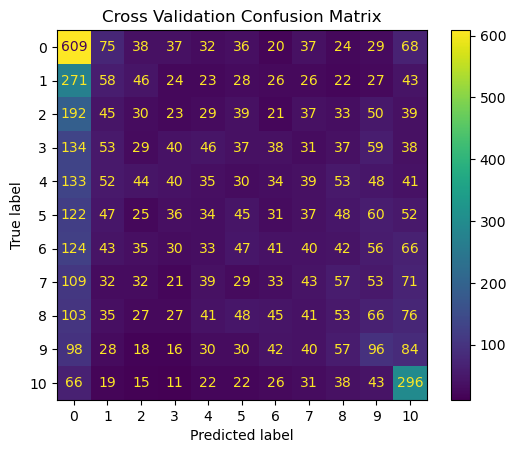

In [ ]:
def generate_cross_val_confusion_matrix(
    cv_model: CrossValidatorModel, test_df: DataFrame
):
    """Generates a confusion matrix for the best model from cross validation"""

    # Generate confusion matrix
    predictionAndLabels = (
        cv_model.transform(test_df)
        .select("class", "prediction")
        .rdd.map(lambda row: (float(row["prediction"]), float(row["class"])))
    )
    class_names = (
        test_df.select("class")
        .distinct()
        .sort("class")
        .rdd.map(lambda row: row[0])
        .collect()
    )
    metrics = MulticlassMetrics(predictionAndLabels)
    con_mtrx = metrics.confusionMatrix().toArray().astype(int)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=con_mtrx, display_labels=class_names)
    disp.plot()
    plt.title("Cross Validation Confusion Matrix")


generate_cross_val_confusion_matrix(cv_model, test_df)

### Explaining best hyperparameters

Now we should explain the best hyperparameters for the cross-validation model.


In [ ]:
print(cv_model.bestModel.explainParam("maxDepth"))
print(cv_model.bestModel.explainParam("numTrees"))

maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30]. (default: 5, current: 20)
numTrees: Number of trees to train (>= 1). (default: 20, current: 50)
